In [2]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper, tfr_morlet
from mne.time_frequency import morlet, fwhm
import tables as tb
import pickle 
import os
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
import os 
import h5py
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats 

%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.regressionplots import plot_fit, plot_partregress_grid
from scipy.stats import sem

In [5]:
def save_epochs(sub,data_dir,epochs):
    # saves Epoch
    epochs.save(data_dir + sub + '-epo.fif', fmt= 'single',overwrite=True)
    
    
def save_ica(subject,directionary,ica):
        
        ica.save(directionary + subject+ '-ica.fif', 
        fmt= 'single', overwrite=True)
        
def make_events(epochs):
    
    
     # separate conditions
    motor_source_event41 = epochs['selftap']
    motor_source_event610 = epochs['VP610']
    motor_source_event620 = epochs['VP620']
    motor_source_event630 = epochs['VP630']
        
        # combine all conditions to one list 
    all_motor_components = [motor_source_event41, motor_source_event610, motor_source_event620, motor_source_event630]
    
    return all_motor_components 

In [3]:
class Data_Processor:
    
    def __init__(self):
        self.ICA = None


    def fit_ica(self, epochs):
        
        #epochs.load_data(dtype=np.float64)
        # run fast ICA 
        ica = mne.preprocessing.ICA(
            n_components=30, method="fastica", max_iter="auto", random_state=97)
        
        self.ICA = ica
        ica.fit(epochs) # fit on epochs
        
        # Visualise ICA components
        montage = mne.channels.make_standard_montage("standard_1005") 
        epochs.set_montage(montage)

        ica.plot_sources(epochs) # plot the raw signal 

        #scalp field topographies 
        ica.plot_components() # plot a Topomap and Chooose ICA compoenents.
        
        
        return self.ICA
    
    def plot_comp(self, epochs, picks, participant_id):
        # Call plot_properties to generate the figures
        figs = self.ICA.plot_properties(epochs, picks=picks, log_scale=False)
        
        # Save each figure separately
        for i, fig in enumerate(figs):
            fig.savefig(f'C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/Dokumenter/Master in AI/Final Thesis/Figures/ICA/ICA_component_{participant_id}_{i}.png')
        
    
    def get_ica_sources(self, epochs, list_of_Ica_components):
        if self.ICA is None:
            raise ValueError("Raw data is not loaded. Call fit_ICA() first.")
        
        all_sources = self.ICA.get_sources(epochs)

        # Get the sources corresponding to the components
        motor_source = all_sources.pick(list_of_Ica_components)
        
        # separate conditions
        motor_source_event41 = motor_source['selftap']
        motor_source_event610 = motor_source['VP610']
        motor_source_event620 = motor_source['VP620']
        motor_source_event630 = motor_source['VP630']
        
        # combine all conditions to one list 
        all_motor_components = [motor_source_event41, motor_source_event610, motor_source_event620, motor_source_event630]
        
        return all_motor_components
            
        del epochs       
        
        return power_by_channel
    
    def baseCorrection_ERDS(self, epochs_power):
    
        # First we average across frequency in alpha and beta band 
        av_freq_alpha = epochs_power.copy().crop(fmin=8, fmax=12).average(dim='freqs')
        av_freq_beta = epochs_power.copy().crop(fmin=15, fmax=25).average(dim='freqs')
        
        

        # Baseline correct ERD's
        baseline = (-0.5,1.5)
        erds_alpha = av_freq_alpha.copy().apply_baseline(baseline, mode='percent', verbose=None)
        erds_beta =  av_freq_beta.copy().apply_baseline(baseline, mode='percent', verbose=None)
        
        
                                                    
        # average across trials
        av_epoch_alpha =  erds_alpha.copy().crop(tmin=-0.5, tmax=1.5).average()
        av_epoch_beta = erds_beta.copy().crop(tmin=-0.5, tmax=1.5).average()
        
    
        
        ERD_pair = (av_epoch_alpha,av_epoch_beta)
        
        
        return ERD_pair
    
    def get_Erdslist(self,powerlist):
        
        erds_list = []
        
        for power in powerlist:
            erdpair = self.baseCorrection_ERDS(power)
            erds_list.append(erdpair)
        
        print("")    
        print("Statistics after organising erds en tuples for alpha 41 trial:")
        print("Mean:", np.mean(erds_list[0][0].data))
        print("Min:", np.min(erds_list[0][0].data))
        print("Max:", np.max(erds_list[0][0].data))
        
        print("Standard deviation:", np.std(erds_list[0][0].data))   
            
        return erds_list
    
    def wavelet_to_ERD(self, epochs):
        
        
         # Perform wavelet analysis
        freqs = np.arange(1, 31)  # Interested in frequencies 1 to 30 Hz
        n_cycles = 3 + 0.125 * freqs  # Number of cycles

        ERDS_by_channel = {}

        for name in epochs.ch_names:
            if name != 'Status':
                
                print(f"name:{name}")
                
                power = mne.time_frequency.tfr_morlet(epochs, freqs, n_cycles, use_fft=False, return_itc=False,
                                                    decim=1, n_jobs=None, zero_mean=True, average=False,
                                                    output='power', picks=name)
                
                pair = self.baseCorrection_ERDS(power)
                
                ERDS_by_channel[name] = pair
                
                print(f"Shape of power array: {power.data.shape}")  
                
        del epochs
        
        return ERDS_by_channel
        

                

direc = "C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/Dokumenter/Thesis Code/Data/Clean_epochs/"
save_epochs('subj_01',direc,epochs_1)

In [43]:
#path = "C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/Dokumenter/Thesis Code/Data/Clean_epochs/"
DP = Data_Processor()
path2 = "C:/Users\Mabel Ife/OneDrive - Danmarks Tekniske Universitet/clean_epochs/subj_50-epo.fif"
epochs = mne.read_epochs(path2,preload=False)
conditions = make_events(epochs)
del epochs


Reading C:\Users\Mabel Ife\OneDrive - Danmarks Tekniske Universitet\clean_epochs\subj_50-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2996.09 ms
        0 CTF compensation matrices available
Not setting metadata
1910 matching events found
No baseline correction applied
0 projection items activated


# Computing ERDS for overly-Adative 

In [21]:
# investitagte C3 and CZ


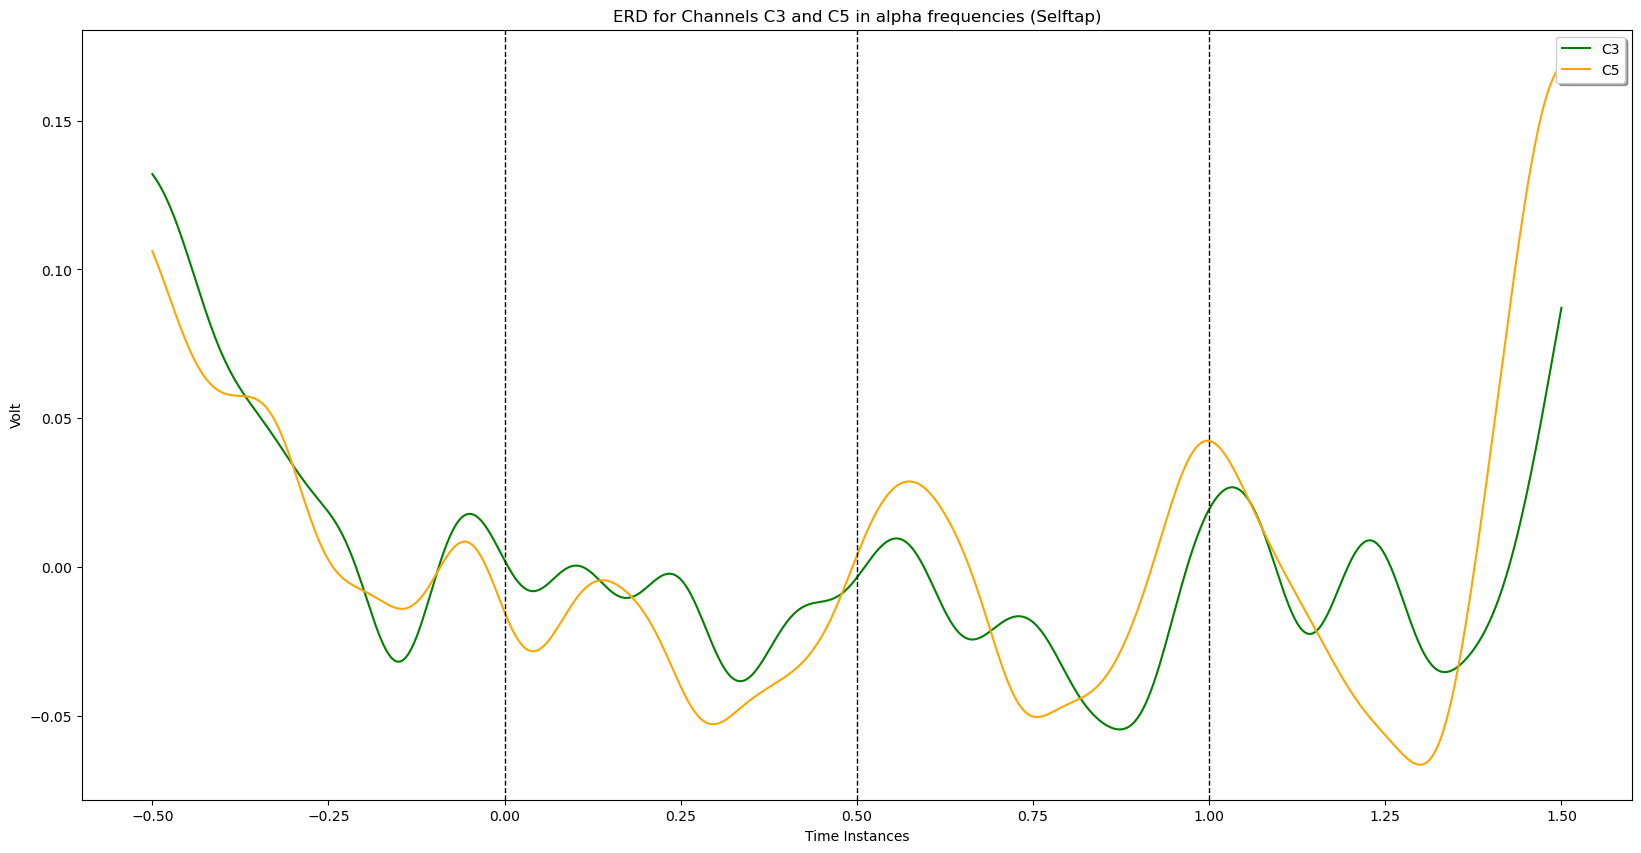

In [29]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# File path
file_path = "D:/Mabel_Thesis/ERDs/Selftap_ERDs.h5"

# Function to plot alpha values for channels C3 and C5
def plot_alpha_values(file_path):
    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as f:
        # Navigate to the alpha datasets for channels C3 and C5
        alpha_C3 = f['Selftap/subject_21/C3_alpha']
        alpha_C5 = f['Selftap/subject_21/C5_alpha']
        
        # Get the data arrays
        data_C3 = alpha_C3[:]
        data_C5 = alpha_C5[:]
        
        # Time axis
        t = np.linspace(-0.5, 1.5, data_C3.shape[2])

        # Plotting
        fig, ax1 = plt.subplots(figsize=(20, 10))
        ax1.set_xlabel('Time Instances')
        ax1.set_ylabel('Volt')
        ax1.plot(t, data_C3[0, 0, :], color='green', label='C3')
        ax1.plot(t, data_C5[0, 0, :], color='orange', label='C5')
        
        # Adding vertical lines at specified time points
        ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)  # at time point 0
        ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=1)  # at time point 0.5
        ax1.axvline(x=1, color='black', linestyle='--', linewidth=1)  # at time point 1
        
        # Add legend
        legend = ax1.legend(loc='upper right', shadow=True, fontsize='medium')
        
        # Title
        plt.title('ERD for Channels C3 and C5 in alpha frequencies (Selftap)')
        
        # Show plot
        plt.show()
        return data_C3, data_C5
    

# Plot alpha values for channels C3 and C5
dc3, dc5 = plot_alpha_values(file_path)



Hej skat! Du er kommet til non-adaptive for subject 31. Du starter bare derfra. 

In [48]:
# This section copmutes the wavelet analysis and creates the ERDs one subject at a time and one condition at time. They 

ERD_channels = DP.wavelet_to_ERD(conditions[3])
base_path = "D:/Mabel_Thesis/ERDs"
# Get the power values for subject 1 and condition 1
subject_id = 50
#condition_name = 'Selftap'
#condition_name = 'Non-adaptive(10)'
#condition_name = 'Moderately-adaptive(20)'
condition_name = 'Overly-adaptive(30)'

# Create an HDF5 file for the condition
file_path = os.path.join(base_path, f'{condition_name}_ERDs.h5')
with h5py.File(file_path, 'a') as f:
    # Create a group for the condition if it doesn't exist
    if condition_name not in f:
        condition_group = f.create_group(condition_name)
    else:
        condition_group = f[condition_name]
    
    
     # Save power values for subject 1 under ID_name
    subject_group = condition_group.create_group(f'subject_{subject_id}')
    for channel_name, (alpha_values, beta_values) in ERD_channels.items():
        # Create datasets for alpha and beta values separately
        subject_group.create_dataset(f'{channel_name}_alpha', data=np.array(alpha_values.data, dtype=np.float64))
        subject_group.create_dataset(f'{channel_name}_beta', data=np.array(beta_values.data, dtype=np.float64))
    
        





name:A1
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:A2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:AF3
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F1
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F3
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F5
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F7
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FT7
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FC5
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FC3
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FC1
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:C1
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:C3
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:C5
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:T7
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:TP7
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:CP5
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:CP3
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:CP1
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P1
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P3
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P5
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P7
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P9
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:PO7
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:PO3
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:O1
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:Iz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:Oz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:POz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:Pz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:CPz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:Fpz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:Fp2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:AF8
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:AF4
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:AFz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:Fz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F4
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F6
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:F8
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FT8
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FC6
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FC4
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FC2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:FCz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:Cz
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:C2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:C4
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:C6
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:T8
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:TP8
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:CP6
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:CP4
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:CP2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P4
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P6
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P8
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:P10
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:PO8
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:PO4
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)
name:O2
Loading data for 320 events and 1280 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Not setting metadata


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Shape of power array: (320, 1, 30, 1280)


In [3]:
file_path = "D:/Mabel_Thesis/ERDs/Selftap_ERDs.h5"
with h5py.File(file_path, 'r') as f:
    i = 0
    print(f.keys())  # Print the keys of the groups in the file
    for group_name, group in f.items():
        print(group_name)
        print(group.keys()) 
    
        
    print(len(group.keys()))

<KeysViewHDF5 ['Selftap']>
Selftap
<KeysViewHDF5 ['subject_1', 'subject_10', 'subject_11', 'subject_12', 'subject_13', 'subject_14', 'subject_15', 'subject_16', 'subject_17', 'subject_18', 'subject_2', 'subject_20', 'subject_21', 'subject_22', 'subject_23', 'subject_24', 'subject_25', 'subject_26', 'subject_27', 'subject_28', 'subject_29', 'subject_3', 'subject_30', 'subject_31', 'subject_32', 'subject_33', 'subject_34', 'subject_35', 'subject_36', 'subject_37', 'subject_38', 'subject_4', 'subject_40', 'subject_41', 'subject_42', 'subject_43', 'subject_46', 'subject_47', 'subject_48', 'subject_49', 'subject_5', 'subject_50', 'subject_7', 'subject_8']>
44


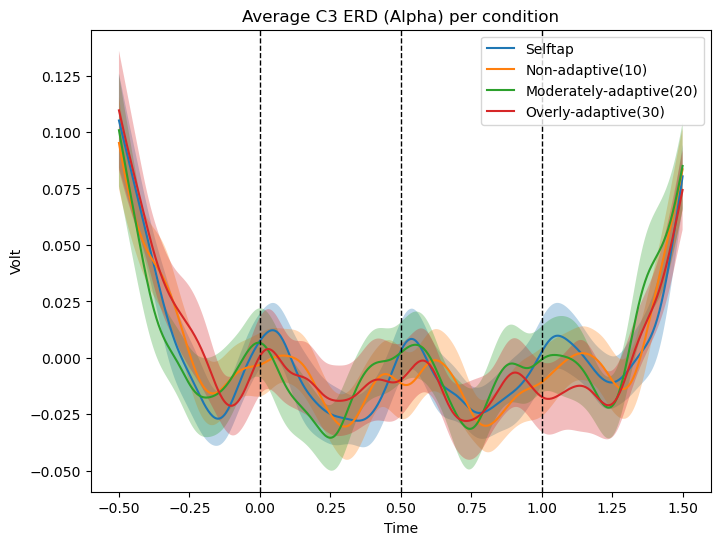

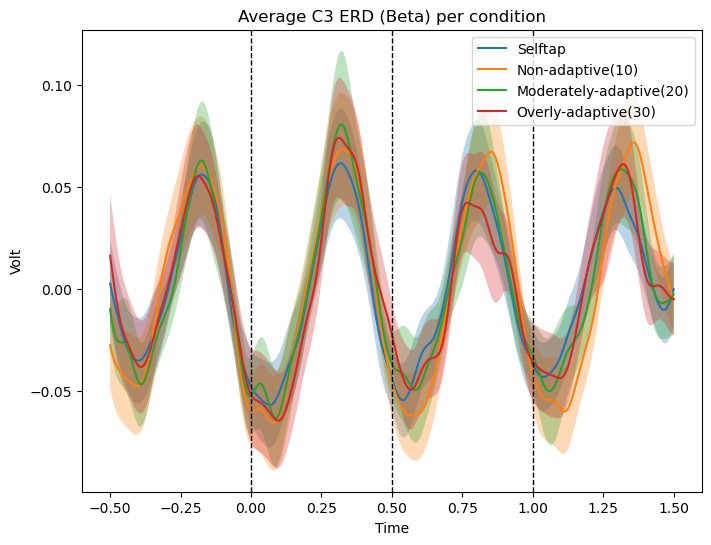

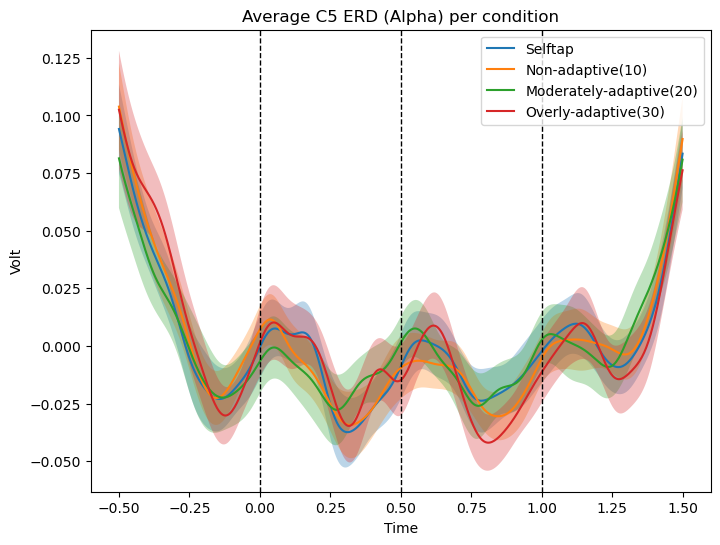

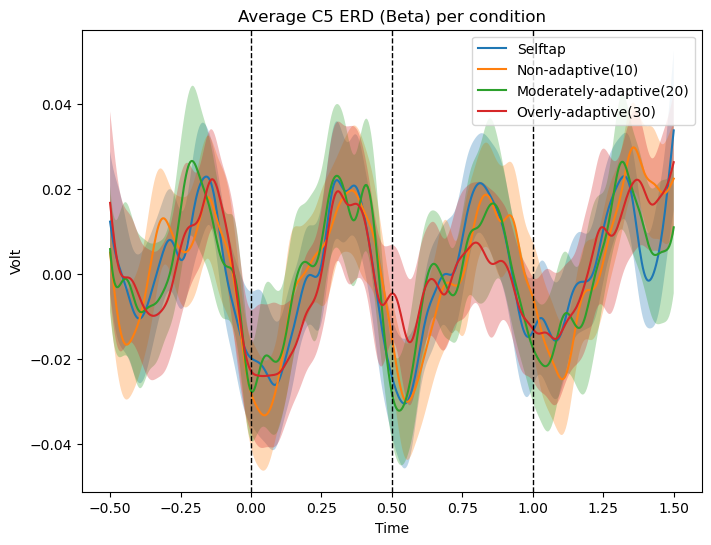

In [4]:

# plot wiht confidence interval 

def plot_average_ERD_all_conditions(base_path, condition_names):
    conditions = condition_names
    num_conditions = len(conditions)

    # Initialize lists to store average ERD values and confidence intervals for each condition and channel
    avg_C3_alpha_all = []
    avg_C3_alpha_ci_all = []
    avg_C3_beta_all = []
    avg_C3_beta_ci_all = []
    avg_C5_alpha_all = []
    avg_C5_alpha_ci_all = []
    avg_C5_beta_all = []
    avg_C5_beta_ci_all = []

    # Loop over all conditions
    for condition_name in conditions:
        condition_path = os.path.join(base_path, condition_name)
        condition_avg_C3_alpha = []
        condition_avg_C3_beta = []
        condition_avg_C5_alpha = []
        condition_avg_C5_beta = []

        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name = condition_name.replace('_ERDs', '')
            condition_group = condition_file[condition_name]
            
            # Access data for each subject in the condition
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]
                if 'C3_alpha' in subject_group:
                    alpha_C3 = subject_group['C3_alpha'][:]
                    beta_C3 = subject_group['C3_beta'][:]
                    
                    condition_avg_C3_alpha.append(np.squeeze(alpha_C3))
                    condition_avg_C3_beta.append(np.squeeze(beta_C3))
                    
                if 'C5_alpha' in subject_group:
                    alpha_C5 = subject_group['C5_alpha'][:]
                    beta_C5 = subject_group['C5_beta'][:]
                    condition_avg_C5_alpha.append(np.squeeze(alpha_C5))
                    condition_avg_C5_beta.append(np.squeeze(beta_C5))

        # Calculate means and confidence intervals
        avg_C3_alpha = np.mean(condition_avg_C3_alpha, axis=0)
        ci_C3_alpha = 1.96 * sem(condition_avg_C3_alpha, axis=0)
        avg_C3_beta = np.mean(condition_avg_C3_beta, axis=0)
        ci_C3_beta = 1.96 * sem(condition_avg_C3_beta, axis=0)
        
        avg_C5_alpha = np.mean(condition_avg_C5_alpha, axis=0)
        ci_C5_alpha = 1.96 * sem(condition_avg_C5_alpha, axis=0)
        avg_C5_beta = np.mean(condition_avg_C5_beta, axis=0)
        ci_C5_beta = 1.96 * sem(condition_avg_C5_beta, axis=0)

        avg_C3_alpha_all.append(avg_C3_alpha)
        avg_C3_alpha_ci_all.append(ci_C3_alpha)
        avg_C3_beta_all.append(avg_C3_beta)
        avg_C3_beta_ci_all.append(ci_C3_beta)
        avg_C5_alpha_all.append(avg_C5_alpha)
        avg_C5_alpha_ci_all.append(ci_C5_alpha)
        avg_C5_beta_all.append(avg_C5_beta)
        avg_C5_beta_ci_all.append(ci_C5_beta)
    
    t = np.linspace(-0.5, 1.5, len(avg_C3_alpha_all[0]))

    # Plot average C3 ERD across all conditions in alpha range with confidence intervals
    fig, ax1 = plt.subplots(figsize=(8, 6))
    for i, condition_name in enumerate(conditions):
        ax1.plot(t, avg_C3_alpha_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax1.fill_between(t, avg_C3_alpha_all[i] - avg_C3_alpha_ci_all[i], avg_C3_alpha_all[i] + avg_C3_alpha_ci_all[i], alpha=0.3)
    ax1.legend()
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax1.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax1.set_title('Average C3 ERD (Alpha) per condition')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Volt')
    plt.show()

    # Plot average C3 ERD across all conditions in beta range with confidence intervals
    fig, ax2 = plt.subplots(figsize=(8, 6))
    for i, condition_name in enumerate(conditions):
        ax2.plot(t, avg_C3_beta_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax2.fill_between(t, avg_C3_beta_all[i] - avg_C3_beta_ci_all[i], avg_C3_beta_all[i] + avg_C3_beta_ci_all[i], alpha=0.3)
    ax2.legend()
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax2.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax2.set_title('Average C3 ERD (Beta) per condition')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volt')
    plt.show()

    # Plot average C5 ERD across all conditions in alpha range with confidence intervals
    fig, ax3 = plt.subplots(figsize=(8, 6))
    for i, condition_name in enumerate(conditions):
        ax3.plot(t, avg_C5_alpha_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax3.fill_between(t, avg_C5_alpha_all[i] - avg_C5_alpha_ci_all[i], avg_C5_alpha_all[i] + avg_C5_alpha_ci_all[i], alpha=0.3)
    ax3.legend()
    ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax3.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax3.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax3.set_title('Average C5 ERD (Alpha) per condition')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Volt')
    plt.show()

    # Plot average C5 ERD across all conditions in beta range with confidence intervals
    fig, ax4 = plt.subplots(figsize=(8, 6))
    for i, condition_name in enumerate(conditions):
        ax4.plot(t, avg_C5_beta_all[i], label=condition_name.replace('_ERDs.h5', ''))
        ax4.fill_between(t, avg_C5_beta_all[i] - avg_C5_beta_ci_all[i], avg_C5_beta_all[i] + avg_C5_beta_ci_all[i], alpha=0.3)
    ax4.legend()
    ax4.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    ax4.axvline(x=1, color='black', linestyle='--', linewidth=1)
    ax4.set_title('Average C5 ERD (Beta) per condition')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Volt')
    plt.show()

# Example usage
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Selftap_ERDs.h5',
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
]

plot_average_ERD_all_conditions(base_path, condition_names)


In [14]:
import h5py

path = "D:/Mabel_Thesis/ERDs/Selftap_ERDs.h5"
# Open the HDF5 file
with h5py.File(path, 'r') as f:
    # Check if the dataset exists
    if 'C3_alpha' in f.keys():
        print("Dataset 'C5_alpha' exists.")
    else:
        print("Dataset 'C5_alpha' does not exist.")


Dataset 'C5_alpha' does not exist.


With Seaborn

c:\Users\Mabel Ife\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mabel Ife\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mabel Ife\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mabel Ife\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

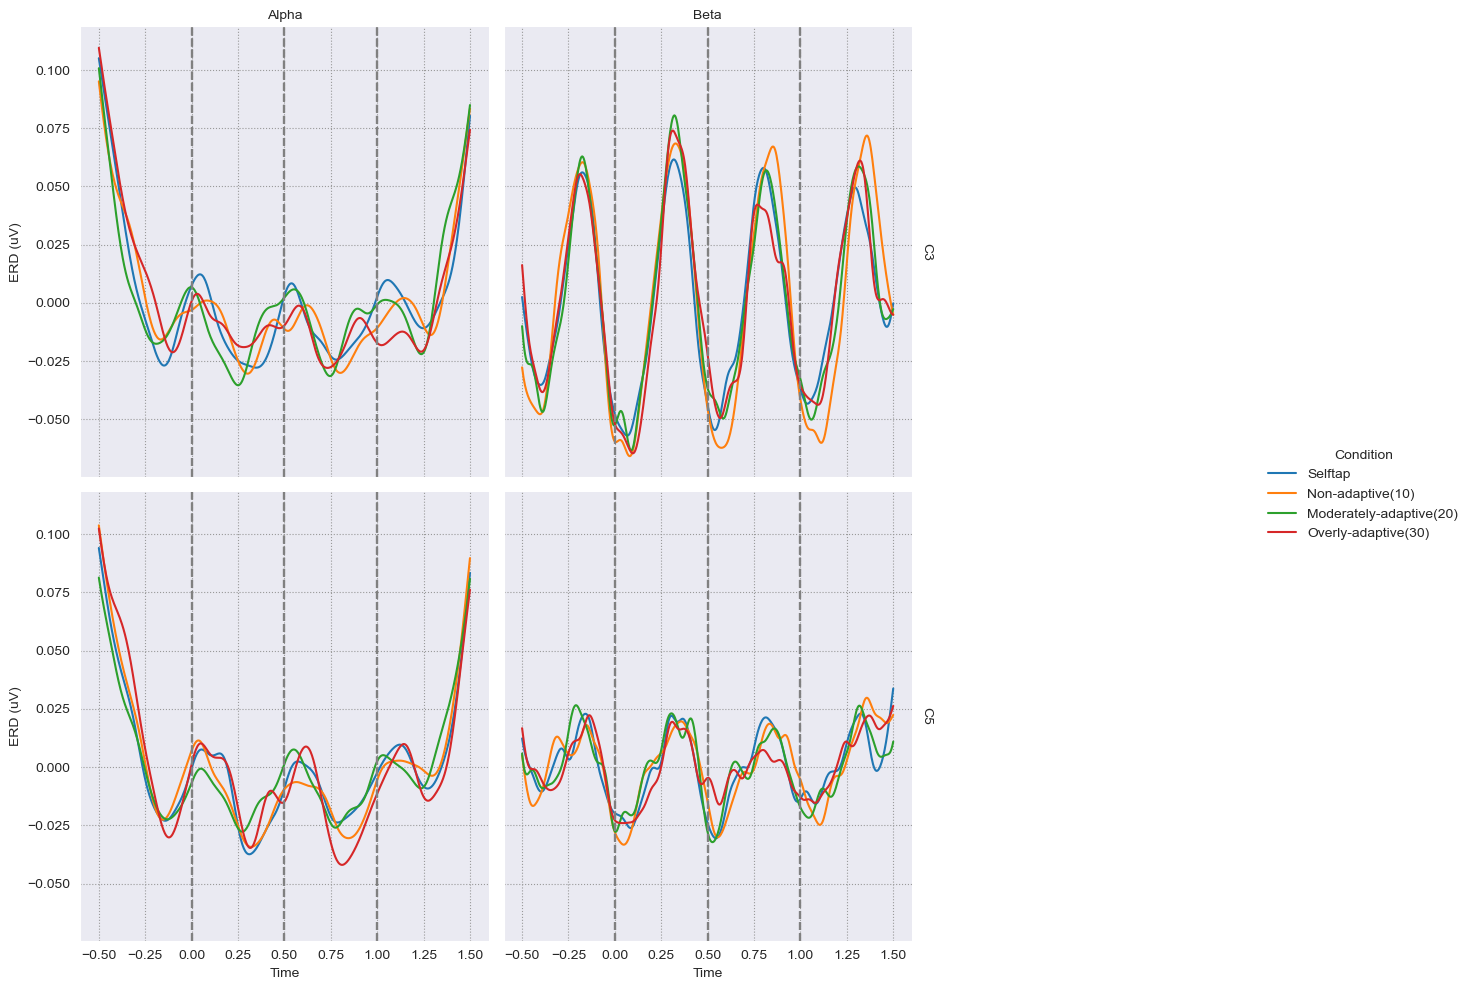

In [10]:
# A plot with seaborn 

def plot_average_ERD_all_conditions(base_path, condition_names):
    conditions = condition_names
    num_conditions = len(conditions)

    # Initialize lists to store average ERD values and confidence intervals for each condition and channel
    avg_C3_alpha_all = []
    avg_C3_alpha_ci_all = []
    avg_C3_beta_all = []
    avg_C3_beta_ci_all = []
    avg_C5_alpha_all = []
    avg_C5_alpha_ci_all = []
    avg_C5_beta_all = []
    avg_C5_beta_ci_all = []

    # Loop over all conditions
    for condition_name in conditions:
        condition_path = os.path.join(base_path, condition_name)
        condition_avg_C3_alpha = []
        condition_avg_C3_beta = []
        condition_avg_C5_alpha = []
        condition_avg_C5_beta = []

        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name_base = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name_base = condition_name_base.replace('_ERDs', '')

            condition_group = condition_file[condition_name_base]
            # Access data for each subject in the condition
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]
                if 'C3_alpha' in subject_group:
                    alpha_C3 = subject_group['C3_alpha'][:]
                    beta_C3 = subject_group['C3_beta'][:]
                    condition_avg_C3_alpha.append(np.squeeze(alpha_C3))
                    condition_avg_C3_beta.append(np.squeeze(beta_C3))
                if 'C5_alpha' in subject_group:
                    alpha_C5 = subject_group['C5_alpha'][:]
                    beta_C5 = subject_group['C5_beta'][:]
                    condition_avg_C5_alpha.append(np.squeeze(alpha_C5))
                    condition_avg_C5_beta.append(np.squeeze(beta_C5))

        # Calculate mean and confidence intervals
        avg_C3_alpha = np.mean(condition_avg_C3_alpha, axis=0)
        ci_C3_alpha = 1.96 * sem(condition_avg_C3_alpha, axis=0)
        avg_C3_beta = np.mean(condition_avg_C3_beta, axis=0)
        ci_C3_beta = 1.96 * sem(condition_avg_C3_beta, axis=0)
        avg_C5_alpha = np.mean(condition_avg_C5_alpha, axis=0)
        ci_C5_alpha = 1.96 * sem(condition_avg_C5_alpha, axis=0)
        avg_C5_beta = np.mean(condition_avg_C5_beta, axis=0)
        ci_C5_beta = 1.96 * sem(condition_avg_C5_beta, axis=0)

        avg_C3_alpha_all.append(avg_C3_alpha)
        avg_C3_alpha_ci_all.append(ci_C3_alpha)
        avg_C3_beta_all.append(avg_C3_beta)
        avg_C3_beta_ci_all.append(ci_C3_beta)
        avg_C5_alpha_all.append(avg_C5_alpha)
        avg_C5_alpha_ci_all.append(ci_C5_alpha)
        avg_C5_beta_all.append(avg_C5_beta)
        avg_C5_beta_ci_all.append(ci_C5_beta)

    # Prepare data for seaborn
    time_points = np.linspace(-0.5, 1.5, len(avg_C3_alpha_all[0]))
    data = []

    for i, condition_name in enumerate(conditions):
        for t, avg, ci in zip(time_points, avg_C3_alpha_all[i], avg_C3_alpha_ci_all[i]):
            data.append([t, avg, ci, condition_name.replace('_ERDs.h5', ''), 'C3', 'Alpha'])
        for t, avg, ci in zip(time_points, avg_C3_beta_all[i], avg_C3_beta_ci_all[i]):
            data.append([t, avg, ci, condition_name.replace('_ERDs.h5', ''), 'C3', 'Beta'])
        for t, avg, ci in zip(time_points, avg_C5_alpha_all[i], avg_C5_alpha_ci_all[i]):
            data.append([t, avg, ci, condition_name.replace('_ERDs.h5', ''), 'C5', 'Alpha'])
        for t, avg, ci in zip(time_points, avg_C5_beta_all[i], avg_C5_beta_ci_all[i]):
            data.append([t, avg, ci, condition_name.replace('_ERDs.h5', ''), 'C5', 'Beta'])

    df = pd.DataFrame(data, columns=['Time', 'Average', 'CI', 'Condition', 'Channel', 'Frequency'])


    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    g = sns.FacetGrid(df, row="Channel", col="Frequency", hue="Condition", margin_titles=True, height=5, legend_out= True)
    g.map_dataframe(sns.lineplot, x= "Time", y="Average", err_style="bars", errorbar=("sd"))
    g.add_legend(title="Condition", bbox_to_anchor=(1.05, 0.5), loc='center left')
    g.refline(x=0)
    g.refline(x=0.5)
    g.refline(x=1)
   
    
    #g.map(plt.fill_between, "Time", "Average-CI", "Average+CI", alpha=0.2).add_legend()
    g.set_axis_labels("Time", "ERD (uV)")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.tight_layout()

    plt.show()
    
    return df

# Base path and condition names
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Selftap_ERDs.h5',
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
]

df_ERDS_c3_c5 = plot_average_ERD_all_conditions(base_path, condition_names)


Condition: Selftap_ERDs.h5, Subject: subject_1, First local minima after X=0: (t=0.188, value=-0.095)
Condition: Selftap_ERDs.h5, Subject: subject_10, First local minima after X=0: (t=0.258, value=-0.054)
Condition: Selftap_ERDs.h5, Subject: subject_11, First local minima after X=0: (t=0.098, value=-0.060)
Condition: Selftap_ERDs.h5, Subject: subject_12, First local minima after X=0: (t=0.289, value=-0.061)
Condition: Selftap_ERDs.h5, Subject: subject_13, First local minima after X=0: (t=0.309, value=-0.035)
Condition: Selftap_ERDs.h5, Subject: subject_14, First local minima after X=0: (t=0.125, value=-0.054)
Condition: Selftap_ERDs.h5, Subject: subject_15, First local minima after X=0: (t=0.199, value=-0.033)
Condition: Selftap_ERDs.h5, Subject: subject_16, First local minima after X=0: (t=0.172, value=-0.007)
Condition: Selftap_ERDs.h5, Subject: subject_17, First local minima after X=0: (t=0.230, value=-0.011)
Condition: Selftap_ERDs.h5, Subject: subject_18, First local minima after 

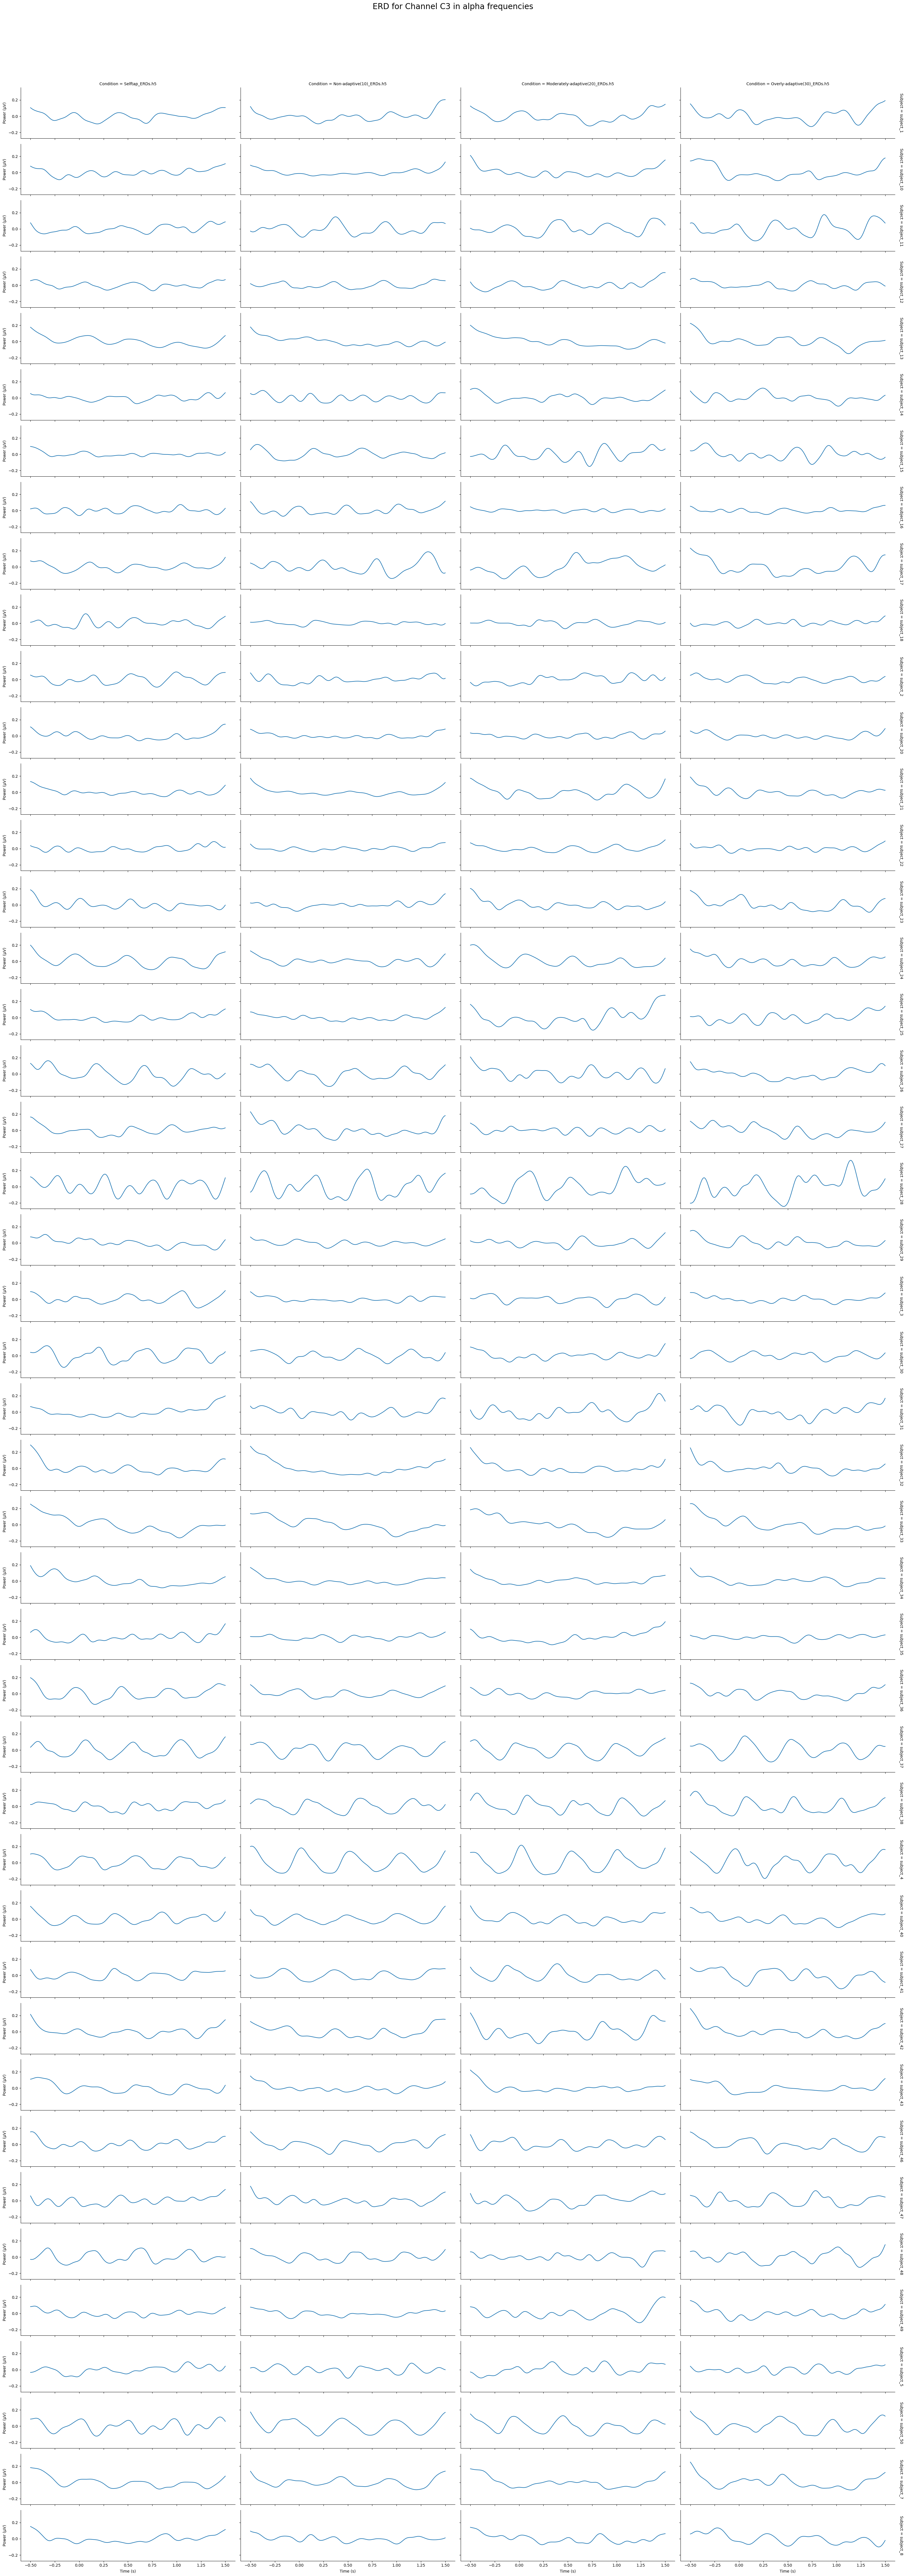

In [35]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from scipy.signal import find_peaks

# File path
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Selftap_ERDs.h5',
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
] # replace with your actual condition names

def extract_beta_values(base_path, condition_names):
    # Prepare lists to store the data
    data_list = []

    # Loop over all conditions
    for condition_name in condition_names:
        condition_path = os.path.join(base_path, condition_name)

        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name_base = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name_base = condition_name_base.replace('_ERDs', '')

            condition_group = condition_file[condition_name_base]

            # Loop through each subject in the condition
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]
                if 'C3_alpha' in subject_group:
                    beta_C3 = subject_group['C3_alpha'][:]
                    
                    # Time axis
                    t = np.linspace(-0.5, 1.5, beta_C3.shape[2])
                    
                    # Flatten the data and store in the list
                    for i in range(len(t)):
                        data_list.append([condition_name, subject_group_name, t[i], beta_C3[0, 0, i]])
                    
                    # Find the first local minima after X = 0
                    post_zero_idx = np.where(t >= 0)[0]
                    post_zero_data = beta_C3[0, 0, post_zero_idx]
                    peaks, _ = find_peaks(-post_zero_data)  # find local minima by inverting the signal
                    
                    if peaks.size > 0:
                        first_minima_idx = post_zero_idx[peaks[0]]
                        first_minima_value = beta_C3[0, 0, first_minima_idx]
                        print(f'Condition: {condition_name}, Subject: {subject_group_name}, First local minima after X=0: (t={t[first_minima_idx]:.3f}, value={first_minima_value:.3f})')
    
    # Create a DataFrame from the data list
    data_df = pd.DataFrame(data_list, columns=["Condition", "Subject", "Time", "Beta_C3"])
    return data_df

def plot_facet_grid(data_df):
    # Create the FacetGrid
    g = sns.FacetGrid(data_df, col="Condition", row="Subject", margin_titles=True, height=2, aspect=4)
    g.map(plt.plot, "Time", "Beta_C3")
    
    # Add axis labels and title
    g.set_axis_labels("Time (s)", "Power (µV)")
    g.fig.suptitle('ERD for Channel C3 in alpha frequencies', fontsize=20, y=1.03)
    
    plt.show()

# Extract the data and plot
data_df = extract_beta_values(base_path, condition_names)
plot_facet_grid(data_df)


Condition: Selftap_ERDs.h5, Subject: subject_1, First local minima after X=0: (t=0.188, value=-0.095)
Condition: Selftap_ERDs.h5, Subject: subject_10, First local minima after X=0: (t=0.258, value=-0.054)
Condition: Selftap_ERDs.h5, Subject: subject_11, First local minima after X=0: (t=0.098, value=-0.060)
Condition: Selftap_ERDs.h5, Subject: subject_12, First local minima after X=0: (t=0.289, value=-0.061)
Condition: Selftap_ERDs.h5, Subject: subject_13, First local minima after X=0: (t=0.309, value=-0.035)
Condition: Selftap_ERDs.h5, Subject: subject_14, First local minima after X=0: (t=0.125, value=-0.054)
Condition: Selftap_ERDs.h5, Subject: subject_15, First local minima after X=0: (t=0.199, value=-0.033)
Condition: Selftap_ERDs.h5, Subject: subject_16, First local minima after X=0: (t=0.172, value=-0.007)
Condition: Selftap_ERDs.h5, Subject: subject_17, First local minima after X=0: (t=0.230, value=-0.011)
Condition: Selftap_ERDs.h5, Subject: subject_18, First local minima after 

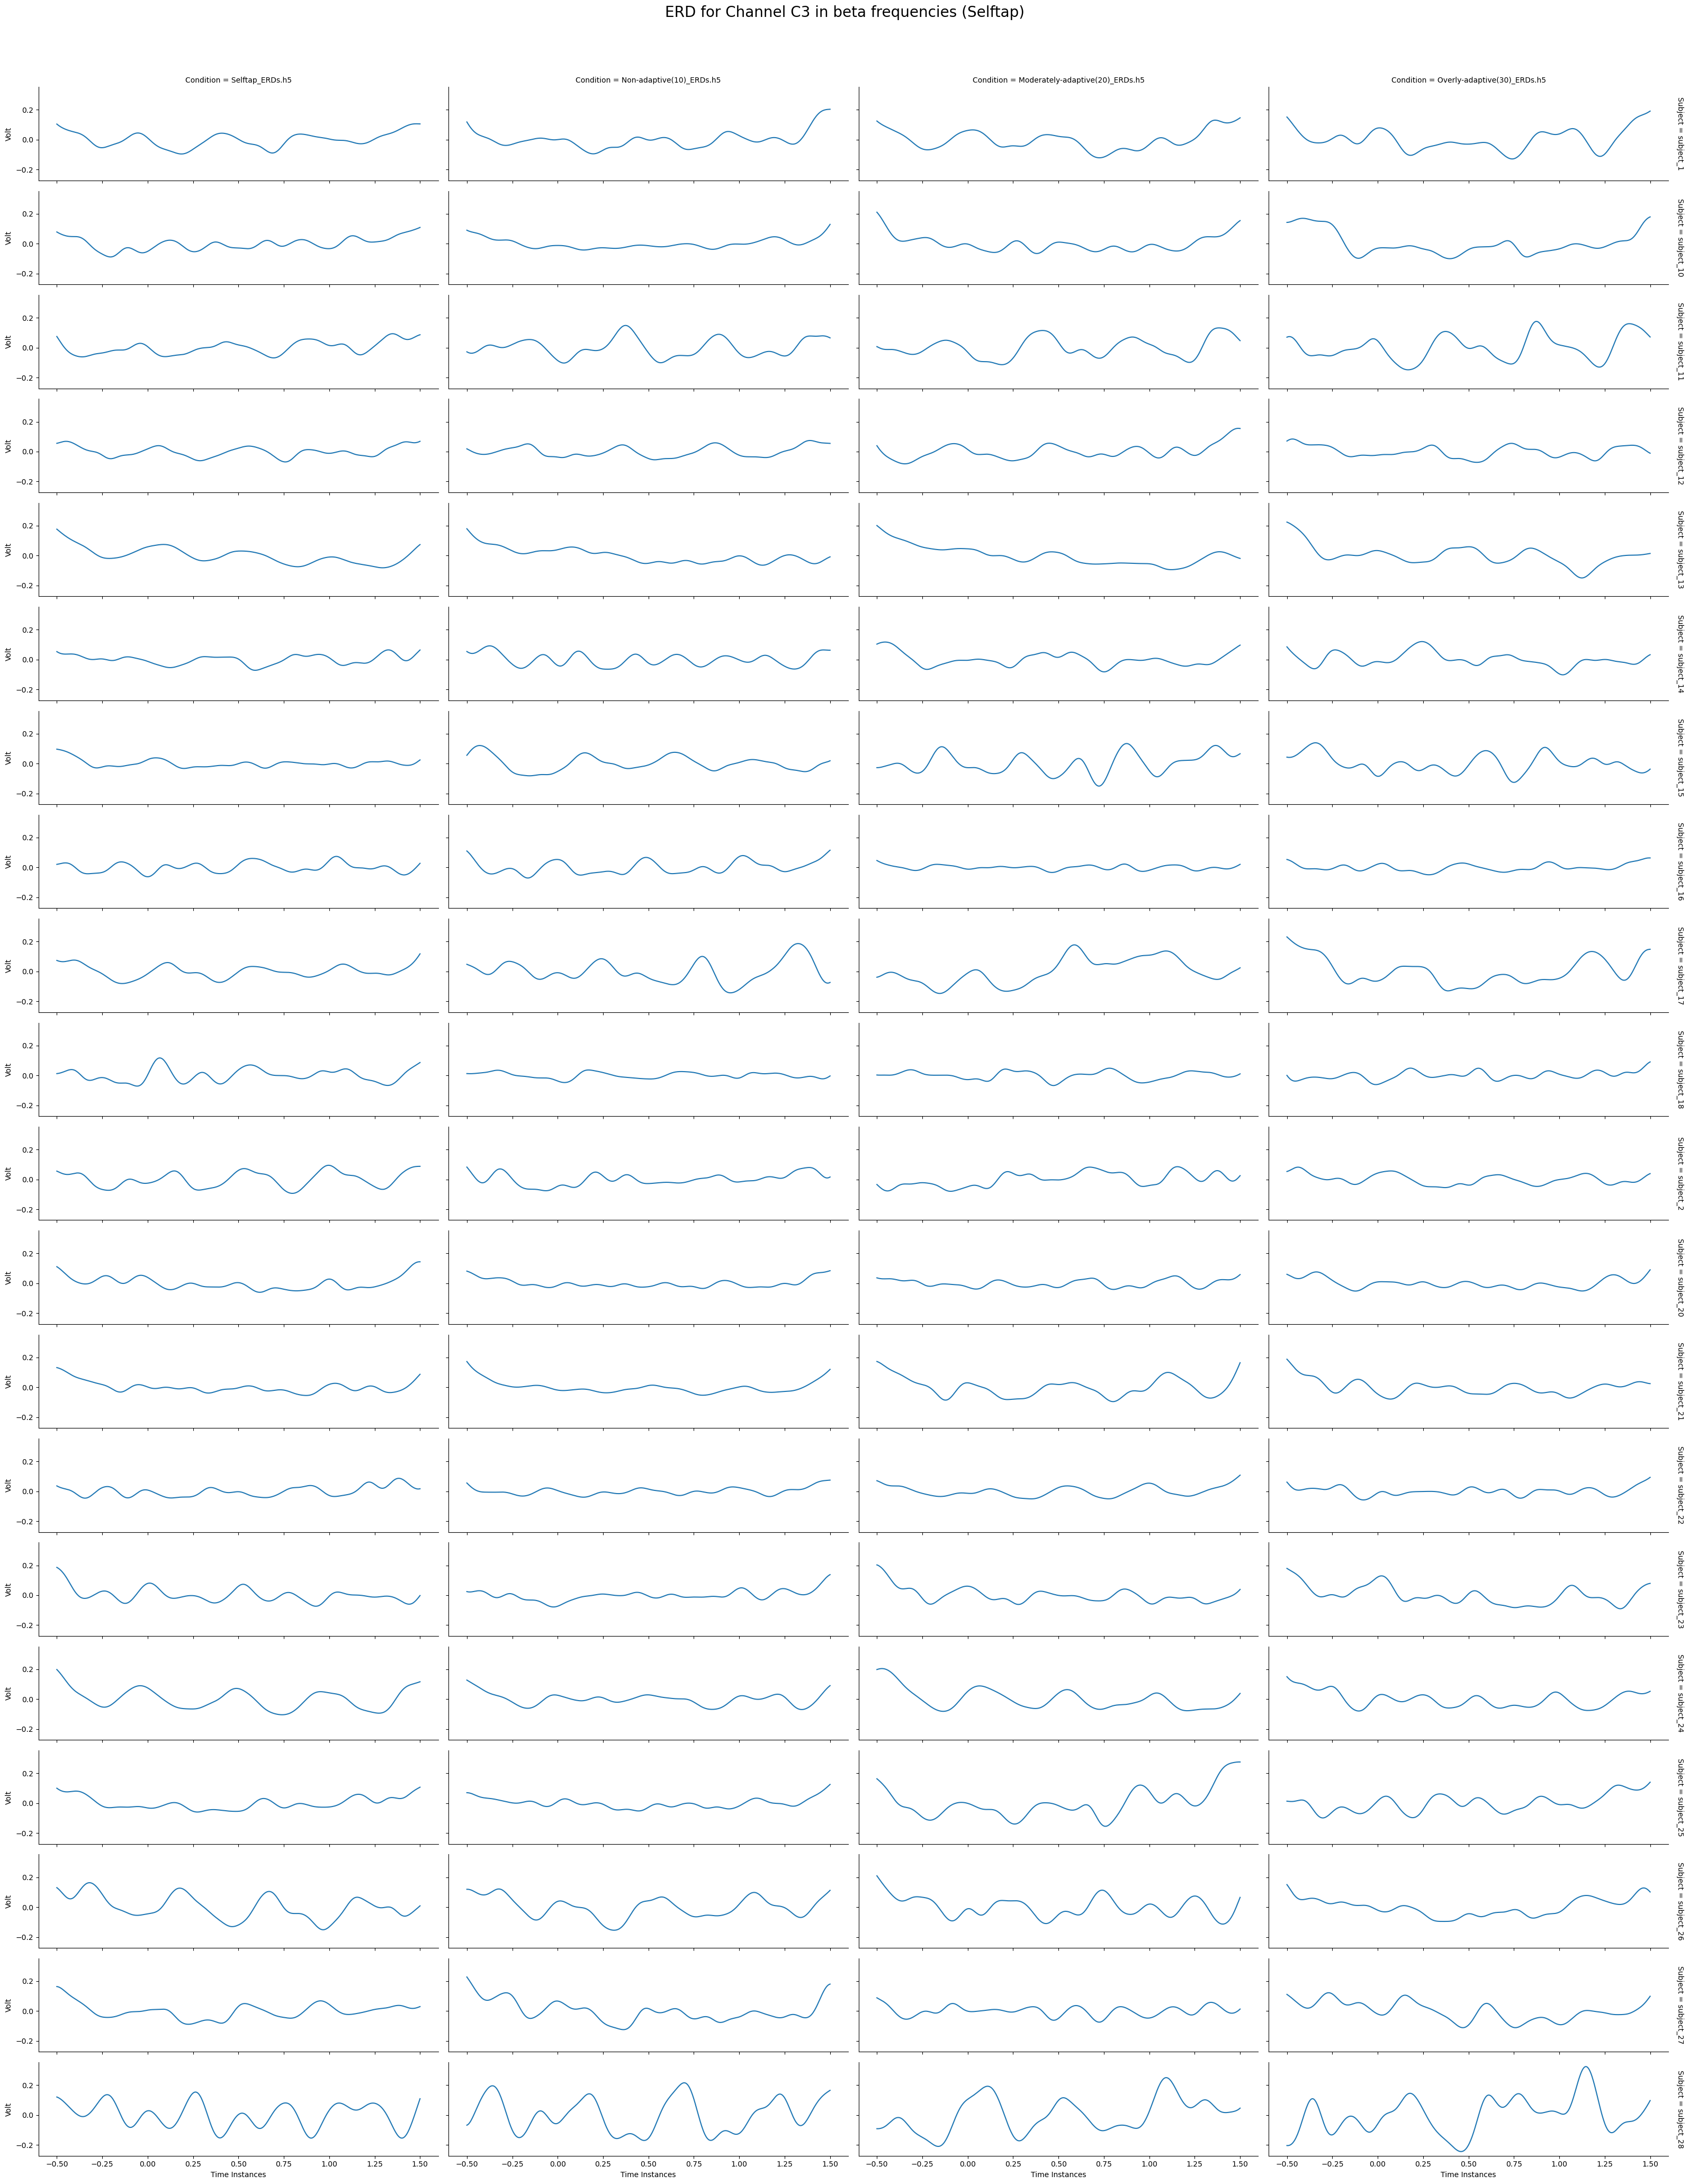

In [3]:

from scipy.signal import find_peaks

# File path
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Selftap_ERDs.h5',
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
] # replace with your actual condition names

def extract_beta_values(base_path, condition_names, max_subjects=20):
    # Prepare lists to store the data
    data_list = []

    # Loop over all conditions
    for condition_name in condition_names:
        condition_path = os.path.join(base_path, condition_name)

        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name_base = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name_base = condition_name_base.replace('_ERDs', '')

            condition_group = condition_file[condition_name_base]

            subject_count = 0 

            # Loop through each subject in the condition
            for subject_group_name in condition_group.keys():
                if subject_count >= max_subjects:
                    break
                
                subject_group = condition_group[subject_group_name]
                if 'C3_alpha' in subject_group:
                    beta_C3 = subject_group['C3_alpha'][:]
                    
                    # Time axis
                    t = np.linspace(-0.5, 1.5, beta_C3.shape[2])
                    
                    # Flatten the data and store in the list
                    for i in range(len(t)):
                        data_list.append([condition_name, subject_group_name, t[i], beta_C3[0, 0, i]])
                    
                    # Find the first local minima after X = 0
                    post_zero_idx = np.where(t >= 0)[0]
                    post_zero_data = beta_C3[0, 0, post_zero_idx]
                    peaks, _ = find_peaks(-post_zero_data)  # find local minima by inverting the signal
                    
                    if peaks.size > 0:
                        first_minima_idx = post_zero_idx[peaks[0]]
                        first_minima_value = beta_C3[0, 0, first_minima_idx]
                        print(f'Condition: {condition_name}, Subject: {subject_group_name}, First local minima after X=0: (t={t[first_minima_idx]:.3f}, value={first_minima_value:.3f})')
                
                subject_count += 1
    
    # Create a DataFrame from the data list
    data_df = pd.DataFrame(data_list, columns=["Condition", "Subject", "Time", "Beta_C3"])
    return data_df

def plot_facet_grid(data_df):
    # Create the FacetGrid
    g = sns.FacetGrid(data_df, col="Condition", row="Subject", margin_titles=True, height=2, aspect=4)
    g.map(plt.plot, "Time", "Beta_C3")
    
    # Add axis labels and title
    g.set_axis_labels("Time Instances", "Volt")
    g.fig.suptitle('ERD for Channel C3 in beta frequencies (Selftap)', fontsize=20, y=1.03)
    
    plt.show()

# Extract the data and plot
data_df = extract_beta_values(base_path, condition_names, max_subjects=20)
plot_facet_grid(data_df)


In [13]:
# We see to investigate which interval we should have for the capture of synchronization and desynchrnoization

from scipy.signal import find_peaks

# File path
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Selftap_ERDs.h5',
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
] # replace with your actual condition names

def extract_beta_values(base_path, condition_names):
    # Prepare lists to store the data and min/max values for each condition
    data_list = []
    min_max_values = {condition: {'min': float('inf'), 'max': float('-inf'), 'min_time': None, 'max_time': None} for condition in condition_names}

    # Loop over all conditions
    for condition_name in condition_names:
        condition_path = os.path.join(base_path, condition_name)

        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name_base = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name_base = condition_name_base.replace('_ERDs', '')

            condition_group = condition_file[condition_name_base]

            # Loop through each subject in the condition
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]
                if 'C3_beta' in subject_group:
                    beta_C3 = subject_group['C3_beta'][:]
                    
                    # Time axis
                    t = np.linspace(-0.5, 1.5, beta_C3.shape[2])
                    
                    # Flatten the data and store in the list
                    for i in range(len(t)):
                        data_list.append([condition_name, subject_group_name, t[i], beta_C3[0, 0, i]])
                    
                    # Find the min and max in the interval -0.2 to 0.2
                    interval_idx = np.where((t >= -0.3) & (t <= 0.3))[0]
                    interval_data = beta_C3[0, 0, interval_idx]
                    ymin = np.min(interval_data)
                    ymax = np.max(interval_data)
                    xmin = t[interval_idx][np.argmin(interval_data)]
                    xmax = t[interval_idx][np.argmax(interval_data)]
                    
                    # Update the overall min and max for the condition
                    if ymin < min_max_values[condition_name]['min']:
                        min_max_values[condition_name]['min'] = ymin
                        min_max_values[condition_name]['min_time'] = xmin
                    if ymax > min_max_values[condition_name]['max']:
                        min_max_values[condition_name]['max'] = ymax
                        min_max_values[condition_name]['max_time'] = xmax
    
    # Print the overall min and max values for each condition
    for condition_name, values in min_max_values.items():
        print(f'Condition: {condition_name}, Overall Min: (ymin={values["min"]:.3f}, x_location={values["min_time"]:.3f}), '
              f'Overall Max: (ymax={values["max"]:.3f}, x_location={values["max_time"]:.3f})')
    
    # Create a DataFrame from the data list
    data_df = pd.DataFrame(data_list, columns=["Condition", "Subject", "Time", "Beta_C3"])
    return data_df

# Extract the data and print overall min and max values for each condition
data_df = extract_beta_values(base_path, condition_names)


Condition: Selftap_ERDs.h5, Overall Min: (ymin=-0.217, x_location=0.086), Overall Max: (ymax=0.320, x_location=-0.180)
Condition: Non-adaptive(10)_ERDs.h5, Overall Min: (ymin=-0.255, x_location=0.070), Overall Max: (ymax=0.336, x_location=0.266)
Condition: Moderately-adaptive(20)_ERDs.h5, Overall Min: (ymin=-0.252, x_location=0.105), Overall Max: (ymax=0.491, x_location=-0.156)
Condition: Overly-adaptive(30)_ERDs.h5, Overall Min: (ymin=-0.245, x_location=0.043), Overall Max: (ymax=0.355, x_location=-0.219)


# Cluster-Based permetuation test 

We conducted a spatial cluster-based permutation test to compare the interactive conditions, focusing specifically on the first tap to capture the desynchronization that occurs across all subjects. As observed in previous plots, not all subjects exhibit the expected pattern, making it challenging to rely solely on the average plot to determine the window of event-related synchronization (ERS) and desynchronization (ERD). Furthermore, our understanding of individual differences suggests that neural activity varies—some people may have shorter or longer resting states than others.

Therefore, to identify the key intervals of synchronization and desynchronization, we analyzed the data within the time window of -0.3 to 0.3 seconds, where we hypothesize that the majority of these processes occur across all subjects. This hypothesis is based on the average plot, as well as visual inspection of data from 20 subjects and the analysis of individual low and high peaks in each condition.

We determined the minimum and maximum values within this interval for each condition. By taking the overall minimum of these lower values and the maximum of the higher values, we establish the outer boundaries that give us an idea of where the critical transitions are happening. We expect the peak of synchronization to occur just before the tap, followed by a desynchronization peak shortly after. By pinpointing these time locations, we can better define the temporal boundaries of these events.
The final chosen time window was [-0.25:0:25].

In [66]:
def get_cluster_pair(base_path, conditions_filenames):
    # Load data from each file into a dictionary
    data = {}
    # Loop over all conditions
    for condition_name in conditions_filenames:
        condition_path = os.path.join(base_path, condition_name)
        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name_base = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name_base = condition_name_base.replace('_ERDs', '')
            
            subjects = list(condition_file[condition_name_base])
            alpha_data = []
            beta_data = []
            
            for subject in subjects:
                subject_data = condition_file[condition_name_base][subject]
                subject_alpha = []
                subject_beta = []
                
                #interval_data = beta_C3[0, 0, interval_idx]
                for key in subject_data.keys():
                    if key.endswith('_alpha'):
                        erd = subject_data[key][:]
                        t = np.linspace(-0.5, 1.5, erd.shape[2])
                        interval_idx = np.where((t >= -0.25) & (t <= 0.25))[0]
                        
                        sub_alpha = erd[0, 0, interval_idx]
                        subject_alpha.append(sub_alpha)
                        
                    elif key.endswith('_beta'):
                        erd = subject_data[key][:]
                        t = np.linspace(-0.5, 1.5, erd.shape[2])
                        interval_idx = np.where((t >= -0.25) & (t <= 0.25))[0]
                        
                        sub_beta = erd[0, 0, interval_idx]
                        subject_beta.append(sub_beta)
                        #subject_beta.append(subject_data[key][:])
                        
                alpha_data.append(np.squeeze(np.array(subject_alpha)))
                beta_data.append(np.squeeze(np.array(subject_beta)))
                
            data[condition_name_base] = {
            'alpha': np.array((alpha_data)),
            'beta': np.array(beta_data)
        }
    # Verify and adjust shape if needed
    for condition, condition_data in data.items():
        for band in ['alpha', 'beta']:
            condition_data[band] = np.array(condition_data[band])
            print(f"{condition} - {band}: {condition_data[band].shape}")
            
    return data
                

# Base path and condition names
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
]           
        
perme_data = get_cluster_pair(base_path,condition_names)   

Non-adaptive(10) - alpha: (44, 64, 129)
Non-adaptive(10) - beta: (44, 64, 129)
Moderately-adaptive(20) - alpha: (44, 64, 129)
Moderately-adaptive(20) - beta: (44, 64, 129)
Overly-adaptive(30) - alpha: (44, 64, 129)
Overly-adaptive(30) - beta: (44, 64, 129)


In [67]:
# prepare the data for the spatial cluster-based permutuation test 
def create_X(clust_data):
    
    conditions = ['Non-Adaptive','Moderately-Adaptive', 'Overly_adaptive']
    
    alpha_10 = clust_data['Non-adaptive(10)']['alpha']
    alpha_20 = clust_data['Moderately-adaptive(20)']['alpha']
    alpha_30 = clust_data['Overly-adaptive(30)']['alpha']
    beta_10 = clust_data['Non-adaptive(10)']['beta']
    beta_20 = clust_data['Moderately-adaptive(20)']['beta']
    beta_30 = clust_data['Overly-adaptive(30)']['beta']

    # Calculate paired differences for each comparison
    X_alpha_1020 = alpha_10 - alpha_20
    X_alpha_1030 = alpha_10 - alpha_30
    X_alpha_2030 = alpha_20 - alpha_30

    X_beta_1020 = beta_10 - beta_20
    X_beta_1030 = beta_10 - beta_30
    X_beta_2030 = beta_20 - beta_30

    # Create a list of tuples containing condition names and corresponding data
    pairs_to_compare = [
        (conditions[0], conditions[1], X_alpha_1020.transpose(0,2,1)),
        (conditions[0], conditions[2], X_alpha_1030.transpose(0,2,1)),
        (conditions[1], conditions[2], X_alpha_2030.transpose(0,2,1)),
        (conditions[0], conditions[1], X_beta_1020.transpose(0,2,1)),
        (conditions[0], conditions[2], X_beta_1030.transpose(0,2,1)),
        (conditions[1], conditions[2], X_beta_2030.transpose(0,2,1))
    ]
    
    

    return pairs_to_compare
        

    

In [68]:
X_list = create_X(perme_data)
for cond1, cond2, X in X_list:
    
    print(X.shape)


(44, 129, 64)
(44, 129, 64)
(44, 129, 64)
(44, 129, 64)
(44, 129, 64)
(44, 129, 64)


mne.stats.permutation_cluster_test(X, threshold=None, n_permutations=1024, tail=0, stat_fun=None, adjacency=None, n_jobs=None, seed=None, max_step=1, exclude=None, step_down_p=0, t_power=1, out_type='indices', check_disjoint=False, buffer_size=1000, verbose=None)[source]


In [70]:
path2 = "C:/Users/Mabel Ife/OneDrive - Danmarks Tekniske Universitet/clean_epochs/subj_50-epo.fif"
epochs = mne.read_epochs(path2, preload=False)
info = epochs.info
del epochs

Reading C:\Users\Mabel Ife\OneDrive - Danmarks Tekniske Universitet\clean_epochs\subj_50-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2996.09 ms
        0 CTF compensation matrices available
Not setting metadata
1910 matching events found
No baseline correction applied
0 projection items activated


In [71]:

from mne.stats import permutation_cluster_test
from mne.viz import plot_compare_evokeds
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from mne.stats import spatio_temporal_cluster_1samp_test, permutation_cluster_1samp_test
from mne.stats import ttest_1samp_no_p
import scipy.stats

def do_clustertest_paired(pairs_to_compare, info):
    alpha_level = 0.05  # significance level
    #tfce = dict(start=1, step=2)  # parameters for TFCE

    # Find channel adjacency
    adj, names = mne.channels.find_ch_adjacency(info, "eeg")
    
    df = 44 - 1  # degrees of freedom for the test
    thresh = scipy.stats.t.ppf(1 - alpha_level, df) 
   
    eeg_picks = mne.pick_types(info, eeg=True, stim=False, include=names ) # Select only EEG channels
    #i=0
    for cond1, cond2, X in pairs_to_compare:
        print("__ __ __ __ __ New test __ __ ___ __ _")
    
        print(f'Now comparing: {cond1} vs {cond2}')
        #X_diff = X[1]-X[0]
        #print(f"Differences in samples: {X_diff.shape}")
        
    
        
        # Perform the cluster-based permutation test
        T_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test(
            X, n_permutations=1024, tail=0, adjacency=None, threshold=None, n_jobs=1)
        
        #i = i+1
        #print(i)
        good_cluster_inds = np.where(cluster_pv < alpha_level)[0]
        for i, cluster_idx in enumerate(good_cluster_inds):
                print(f"Significant cluster {i + 1}:")
                print(f"  p-value: {cluster_pv[cluster_idx]:.4f}")
                print(f"  t-value range: {T_obs[clusters[cluster_idx]].min()} to {T_obs[clusters[cluster_idx]].max()}")
                
          # Convert data to MNE Evoked objects
         # Create a directory to save the figures
        #save_dir = "clusterbased"
        #os.makedirs(save_dir, exist_ok=True)
        
        #data_cond1 = np.mean(X[0], axis=0)  # Average across subjects
        #data_cond2 = np.mean(X[1], axis=0)  # Average across subjects       
        
        if good_cluster_inds.size > 0:
            
            colors = {cond1: "crimson", cond2: "steelblue"}
            linestyles = {cond1: "-", cond2: "-"}

            

            evokeds = {
                cond2: mne.EvokedArray(data_cond2.transpose(1,0), mne.pick_info(info, eeg_picks)),
                cond1: mne.EvokedArray(data_cond1.transpose(1,0), mne.pick_info(info, eeg_picks)),
            }

          
            for i_clu, clu_idx in enumerate(good_cluster_inds):
                
                time_inds, space_inds = np.squeeze(clusters[clu_idx])
                ch_inds = np.unique(space_inds)
                print(f"print ch_inds length {len(ch_inds)}:")
                #print(space_inds.shape)
                time_inds = np.unique(time_inds)
                #print(T_obs.shape)
                #_= T_obs.transpose(1,0)
                t_map = T_obs[time_inds, ...].mean(axis=0)
                #print(f"shape of f-map: {f_map.shape}") 
                sig_times = evokeds[cond1].times[time_inds]
                #print(f"shape of f-map {f_map.shape[0]}")
                mask = np.zeros((t_map.shape[0], 1), dtype=bool)
                print(mask.shape)
                mask[ch_inds, :] = True
                
                
                cluster_channel_names = [names[ch] for ch in ch_inds]
            
                if len(ch_inds) > 35:
                    print(f"Cluster {i + 1} contains more than 35 channels.")
                    non_cluster_channels = [ch_name for ch_name in names if ch_name not in cluster_channel_names]
                    print("Channels not in the cluster:")
                    print(non_cluster_channels)
                else:
                    print("Channels in the cluster:")
                    print(cluster_channel_names)

                
                

                fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")
                #_= f_map.transpose(0,1)
                t_evoked = mne.EvokedArray(t_map[:, np.newaxis], mne.pick_info(info, eeg_picks), tmin=0)
                t_evoked.plot_topomap(
                    times=0,
                    mask=mask,
                    axes=ax_topo,
                    cmap="Reds",
                    vlim=(np.min, np.max),
                    show=False,
                    colorbar=False,
                    mask_params=dict(markersize=10),
                )
                image = ax_topo.images[0]
                ax_topo.set_title("")

                divider = make_axes_locatable(ax_topo)
                ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(image, cax=ax_colorbar)
                ax_topo.set_xlabel(
                    "Averaged T-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )

                ax_signals = divider.append_axes("right", size="300%", pad=1.2)
                title = f"Cluster #{i_clu + 1}, {len(ch_inds)} sensor"
                if len(ch_inds) > 1:
                    title += "s (mean)"
                plot_compare_evokeds(
                    evokeds,
                    title=title,
                    picks=ch_inds,
                    axes=ax_signals,
                    colors=colors,
                    linestyles=linestyles,
                    show=False,
                    split_legend=True,
                    truncate_yaxis="auto",
                )

                ax_signals.axvline(x=0, color='gray', linestyle='--', linewidth=1)
                ax_signals.axvline(x=0.5, color='gray', linestyle='--', linewidth=1)
                ax_signals.axvline(x=1, color='gray', linestyle='--', linewidth=1)
                
                ymin, ymax = ax_signals.get_ylim()
                ax_signals.fill_betweenx(
                    (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
                )
                
                
                
                fig.suptitle(f"Evoked responses for cluster_channels ({cond1} and {cond2})", fontsize=16, y=1.05)
                plt.show()
            
            
                    

           

do_clustertest_paired(X_list,info)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64
__ __ __ __ __ New test __ __ ___ __ _
Now comparing: Non-Adaptive vs Moderately-Adaptive
Using a threshold of 2.016692
stat_fun(H1): min=-1.941783 max=4.263906
Running initial clustering …
Found 25 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: Non-Adaptive vs Overly_adaptive
Using a threshold of 2.016692
stat_fun(H1): min=-3.119910 max=3.318608
Running initial clustering …
Found 24 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: Moderately-Adaptive vs Overly_adaptive
Using a threshold of 2.016692
stat_fun(H1): min=-3.905095 max=2.735329
Running initial clustering …
Found 37 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: Non-Adaptive vs Moderately-Adaptive
Using a threshold of 2.016692
stat_fun(H1): min=-3.257843 max=3.119655
Running initial clustering …
Found 46 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: Non-Adaptive vs Overly_adaptive
Using a threshold of 2.016692
stat_fun(H1): min=-4.535932 max=4.069186
Running initial clustering …
Found 62 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

__ __ __ __ __ New test __ __ ___ __ _
Now comparing: Moderately-Adaptive vs Overly_adaptive
Using a threshold of 2.016692
stat_fun(H1): min=-2.722418 max=3.190807
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

# Linear Mixed Model with BPT values 

In [6]:
import h5py
import pandas as pd
import numpy as np
import os
from scipy.signal import find_peaks

# File path
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Selftap_ERDs.h5',
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
] 



def get_lower_peak_postions(base_path, condition_names):
    # Prepare lists to store the data
    data_list = []

    # Loop over all conditions
    for condition_name in condition_names:
        condition_path = os.path.join(base_path, condition_name)

        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name_base = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name_base = condition_name_base.replace('_ERDs', '')

            condition_group = condition_file[condition_name_base]

            # Loop through each subject in the condition
            for subject_group_name in condition_group.keys():
                subject_group = condition_group[subject_group_name]
                if 'C3_alpha' in subject_group:
                    beta_C3 = subject_group['C3_alpha'][:]
                    
                    # Time axis
                    t = np.linspace(-0.5, 1.5, beta_C3.shape[2])
                    
                    # Flatten the data and store in the list
                    for i in range(len(t)):
                        data_list.append([condition_name, subject_group_name, t[i], beta_C3[0, 0, i]])
                    
                    # Find the min and max in the interval -0.2 to 0.2
                    interval_idx = np.where((t >= -0.2) & (t <= 0.2))[0]
                    interval_data = beta_C3[0, 0, interval_idx]
                    ymin = np.min(interval_data)
                    ymax = np.max(interval_data)
                    xmin = t[interval_idx][np.argmin(interval_data)]
                    xmax = t[interval_idx][np.argmax(interval_data)]
                    
                    print(f'Condition: {condition_name}, Subject: {subject_group_name}, Min: (ymin={ymin:.3f}, x_location={xmin:.3f}), Max: (ymax={ymax:.3f}, x_location={xmax:.3f})')
    
    # Create a DataFrame from the data list
    BetaC3_lowpeak_df = pd.DataFrame(data_list, columns=["Condition", "Subject", "Time", "Beta_C3"])
    return BetaC3_lowpeak_df

# Extract the data and print min and max values
BetaC3_lowpeak_d = get_lower_peak_postions(base_path, condition_names)


Condition: Selftap_ERDs.h5, Subject: subject_1, Min: (ymin=-0.095, x_location=0.188), Max: (ymax=0.045, x_location=-0.055)
Condition: Selftap_ERDs.h5, Subject: subject_10, Min: (ymin=-0.088, x_location=-0.199), Max: (ymax=0.023, x_location=0.125)
Condition: Selftap_ERDs.h5, Subject: subject_11, Min: (ymin=-0.060, x_location=0.098), Max: (ymax=0.029, x_location=-0.043)
Condition: Selftap_ERDs.h5, Subject: subject_12, Min: (ymin=-0.047, x_location=-0.199), Max: (ymax=0.040, x_location=0.059)
Condition: Selftap_ERDs.h5, Subject: subject_13, Min: (ymin=-0.019, x_location=-0.199), Max: (ymax=0.074, x_location=0.086)
Condition: Selftap_ERDs.h5, Subject: subject_14, Min: (ymin=-0.054, x_location=0.125), Max: (ymax=0.018, x_location=-0.109)
Condition: Selftap_ERDs.h5, Subject: subject_15, Min: (ymin=-0.033, x_location=0.199), Max: (ymax=0.038, x_location=0.047)
Condition: Selftap_ERDs.h5, Subject: subject_16, Min: (ymin=-0.062, x_location=0.000), Max: (ymax=0.038, x_location=-0.145)
Condition:

In [36]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# read BPT excel file into script
df_BPT = pd.read_excel('db.xlsx')

print(df_BPT.head())

   ID  Mean_traits
0   1     1.583333
1   2     1.833333
2   3     2.041667
3   4     2.125000
4   5     2.375000


In [ ]:

# File path
base_path = "D:/Mabel_Thesis/ERDs"
condition_names = [
    'Non-adaptive(10)_ERDs.h5',
    'Moderately-adaptive(20)_ERDs.h5',
    'Overly-adaptive(30)_ERDs.h5'
]  

def LMM_prep(base_path, condition_names, df_BPT):
    #
    condition_dfs_alp = {}
    condition_dfs_bet = {} 
    
    
    # Loop over all conditions
    for condition_name in condition_names:
        condition_path = os.path.join(base_path, condition_name)
        data_list_alp = []
        data_list_bet = []

        # Open the HDF5 file for the condition
        with h5py.File(condition_path, 'r') as condition_file:
            condition_name_base = os.path.splitext(os.path.basename(condition_path))[0]
            condition_name_base = condition_name_base.replace('_ERDs', '')

            condition_group = condition_file[condition_name_base]

            
            for subject_group_name in condition_group.keys():
                print()
                subject_group = condition_group[subject_group_name]
                
                if 'C3_beta' in subject_group:
                    beta_C3 = subject_group['C3_beta'][:]
                    
                    # Time axis
                    t = np.linspace(-0.5, 1.5, beta_C3.shape[2])
                    
                
                    interval_idx = np.where((t >= -0.25) & (t <= 0.25))[0]
                    interval_data = beta_C3[0, 0, interval_idx]
                    
                    # Calculate mean ERD in the interval
                    mean_ERD_bet = np.mean(interval_data)
                    
                  
                    subject_number = int(subject_group_name.replace('subject_', ''))
                    data_list_bet.append([subject_number, mean_ERD_bet])
                    
                if 'C3_alpha' in subject_group:
                    
                    
                    alpha_C3 = subject_group['C3_alpha'][:]
                            
                            # Time axis
                    t = np.linspace(-0.5, 1.5, alpha_C3.shape[2])
                            
                        
                    interval_idx = np.where((t >= -0.25) & (t <= 0.25))[0]
                    interval_data = alpha_C3 [0, 0, interval_idx]
                            
                    # Calculate mean ERD in the interval
                    mean_ERD_alp = np.mean(interval_data)
                            
                    # Add data to the list
                    subject_number = int(subject_group_name.replace('subject_', ''))
                    data_list_alp.append([subject_number, mean_ERD_alp])            
                            

        condition_df1 = pd.DataFrame(data_list_alp, columns=["Subject", "Mean_ERD"])
        condition_df2 = pd.DataFrame(data_list_bet, columns=["Subject", "Mean_ERD"])
    
        
        # Sorts by 'Subject' to maintain order
        condition_df1 = condition_df1.sort_values(by='Subject').reset_index(drop=True)
        condition_df1 = condition_df1.sort_values(by='Subject').reset_index(drop=True)
        
        
        # Converts 'Subject' in df_BPT to integer and filter subjects
        df_BPT['ID'] = df_BPT['ID'].astype(int)
        df_BPT_filtered = df_BPT[df_BPT['ID'].isin(condition_df1['Subject'])]

        # Sorts df_BPT_filtered by 'ID' 
        df_BPT_filtered = df_BPT_filtered.sort_values(by='ID').reset_index(drop=True)

        # Merge with BPT traits, ensuring order is preserved
        merged_df1 = pd.merge(condition_df1, df_BPT_filtered, left_on='Subject', right_on='ID')
        merged_df2 = pd.merge(condition_df2, df_BPT_filtered, left_on='Subject', right_on='ID')
        
        merged_df1 = merged_df1.drop(columns=['ID'])
        merged_df2 = merged_df2.drop(columns=['ID'])
        
        

        
        condition_dfs_alp[condition_name_base] = merged_df1
        condition_dfs_bet[condition_name_base] = merged_df2
        
    # Dataframes for all conditions into one dataframe
    all_conditions_alp = pd.concat(condition_dfs_alp.values(), keys=condition_dfs_alp.keys(), names=['Condition', 'Index']).reset_index(level='Condition')
    all_conditions_bet = pd.concat(condition_dfs_bet.values(), keys=condition_dfs_bet.keys(), names=['Condition', 'Index']).reset_index(level='Condition')
    print(f"Final dataframe alpha: {all_conditions_alp.head(44)}")
    print(f"Final dataframe beta: {all_conditions_bet.head(44)}")
    
    
    
    all_conditions_alp.to_csv('alfa_BPT_ERD.csv', index=False)
    all_conditions_bet.to_csv('beta_BPT_ERD.csv', index=False)
    
    






In [ ]:
LMM_prep(base_path, condition_names, df_BPT)